# Multi-grid window deformation algorithm tutorial

In [ ]:
# import packages

In [1]:
from openpiv import windef  # <---- see windef.py for details
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline  

## Set up all the settings: 

1. where the images are
2. where to save the results
3. names of the image files
4. what is the region of interest
5. do you apply dynamic masking or a masking image
6. what kind of correlation to apply: circular vs linear 
7. interrogation window sizes, overlap sizes, number of iterations
8. time interval, interpolation options, etc.

Read the tutorial by Theo Kaufer with all the details. See `windef.py` for more code details

In [2]:
settings = windef.Settings()


'Data related settings'
# Folder with the images to process
settings.filepath_images = '../../examples/test1/'
# Folder for the outputs
settings.save_path = '../../../examples/test1/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'exp1_001_a.bmp'
settings.frame_pattern_b = 'exp1_001_b.bmp'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'

'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
settings.dynamic_masking_method = 'None'
settings.dynamic_masking_threshold = 0.005
settings.dynamic_masking_filter_size = 7

settings.deformation_method = 'symmetric'

'Processing Parameters'
settings.correlation_method='circular'  # 'circular' or 'linear'
settings.normalized_correlation=False

settings.num_iterations = 2  # select the number of PIV passes
# add the interroagtion window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes = (64, 32, 16) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
settings.overlap = (32, 16, 8) # This is 50% overlap
# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'
# order of the image interpolation for the window deformation
settings.interpolation_order = 3
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
# settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN
'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True
# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated
'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.MinMax_U_disp = (-30, 30)
settings.MinMax_V_disp = (-30, 30)
# The second filter is based on the global STD threshold
settings.std_threshold = 7  # threshold of the std validation
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median
'Validation based on the signal to noise ratio'
# Note: only available when extract_sig2noise==True and only for the last
# pass of the interrogation
# Enable the signal to noise ratio validation. Options: True or False
# settings.do_sig2noise_validation = False # This is time consuming
# minmum signal to noise ratio that is need for a valid vector
settings.sig2noise_threshold = 1.2
'Outlier replacement or Smoothing options'
# Replacment options for vectors which are masked as invalid by the validation
settings.replace_vectors = True # Enable the replacment. Chosse: True or False
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter
# select a method to replace the outliers: 'localmean', 'disk', 'distance'
settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 4
settings.filter_kernel_size = 2  # kernel size for the localmean method
'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

## Run the `windef.py` function, called `piv` with these settings

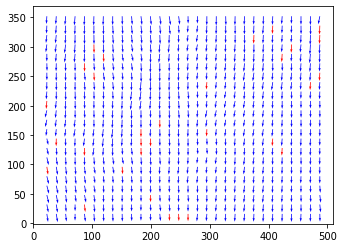

Image Pair 1
exp1_001_a.bmp exp1_001_b.bmp


In [3]:
windef.piv(settings)

## Run the extended search area PIV for comparison

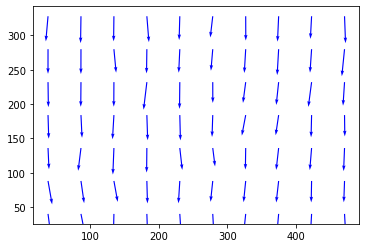

In [5]:

# we can run it from any folder
path = settings.filepath_images


frame_a  = tools.imread( os.path.join(path,settings.frame_pattern_a))
frame_b  = tools.imread( os.path.join(path,settings.frame_pattern_b))

frame_a = (frame_a).astype(np.int32)
frame_b = (frame_b).astype(np.int32)

u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
    window_size=32, overlap=16, dt=1, search_area_size=64, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, 
                               search_area_size=64, overlap=16 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 1)
x, y, u, v = tools.transform_coordinates(x, y, u, v)
tools.save(x, y, u, v, mask, 'test1.vec' )
tools.display_vector_field('test1.vec', scale=75, width=0.0035);